In [47]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt

current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

folder_path = "Paper Experiment Results/New_filtered/creativity"
output_photo_name = f"CT_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["weight_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)


def label_function(x):
    if str(x).startswith("Yes"):
        return True
    elif str(x).startswith("No"):
        return False
    else:
        return None


df["label"] = df["OpenAI_response"].apply(label_function)
df = df[~df["label"].isna()]
df = df[df["Temperature"] != "temperature"]
df["Temperature"] = df["Temperature"].astype(float).round(1)
df.drop_duplicates(subset=["pure_response"], keep="first", inplace=True)

0
1
2
3
4
5
6


<Figure size 4000x600 with 0 Axes>

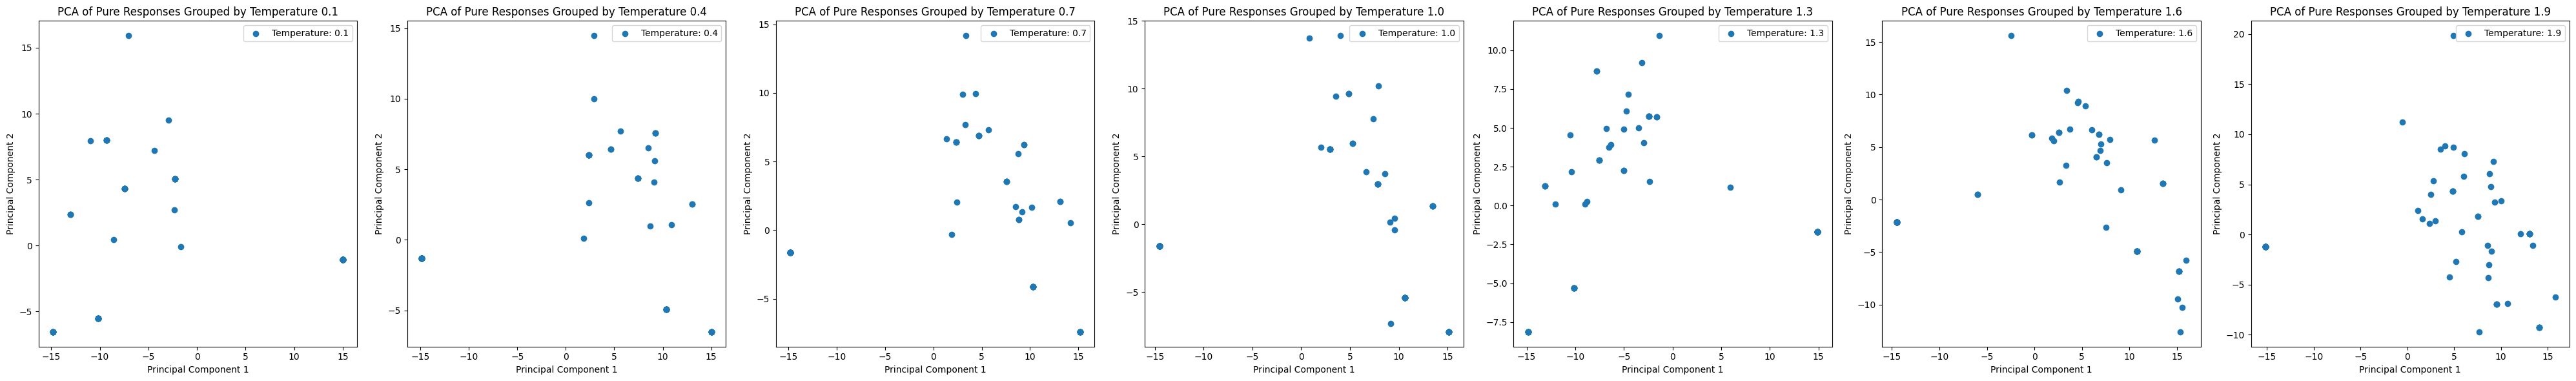

In [51]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from transformers import BertModel, BertTokenizer
from transformers import GPT2Tokenizer, GPT2Model
import torch

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")


def get_paragraph_embedding(paragraph):
    inputs = tokenizer(paragraph, return_tensors="pt", max_length=1024, truncation=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].detach().numpy()


temperatures = df["Temperature"].tolist()
grouped_responses = {}
for index, row in df.iterrows():
    temp = row["Temperature"]
    if row["Temperature"] not in grouped_responses:
        grouped_responses[temp] = []
    grouped_responses[temp].append(index)

plt.figure(figsize=(40, 6))

fig, axs = plt.subplots(1, 7, figsize=(40, 6))

for i, (temp, indices) in enumerate(grouped_responses.items()):
    print(i)
    group_responses = df.loc[indices, "pure_response"].tolist()
    embeddings = np.vstack(
        [get_paragraph_embedding(response) for response in group_responses]
    )
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    axs[i].scatter(
        reduced_embeddings[:, 0], reduced_embeddings[:, 1], label=f"Temperature: {temp}"
    )
    axs[i].set_xlabel("Principal Component 1")
    axs[i].set_ylabel("Principal Component 2")
    axs[i].set_title(f"PCA of Pure Responses Grouped by Temperature {temp}")
    axs[i].legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_2079397/3846209208.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(grouped_responses))


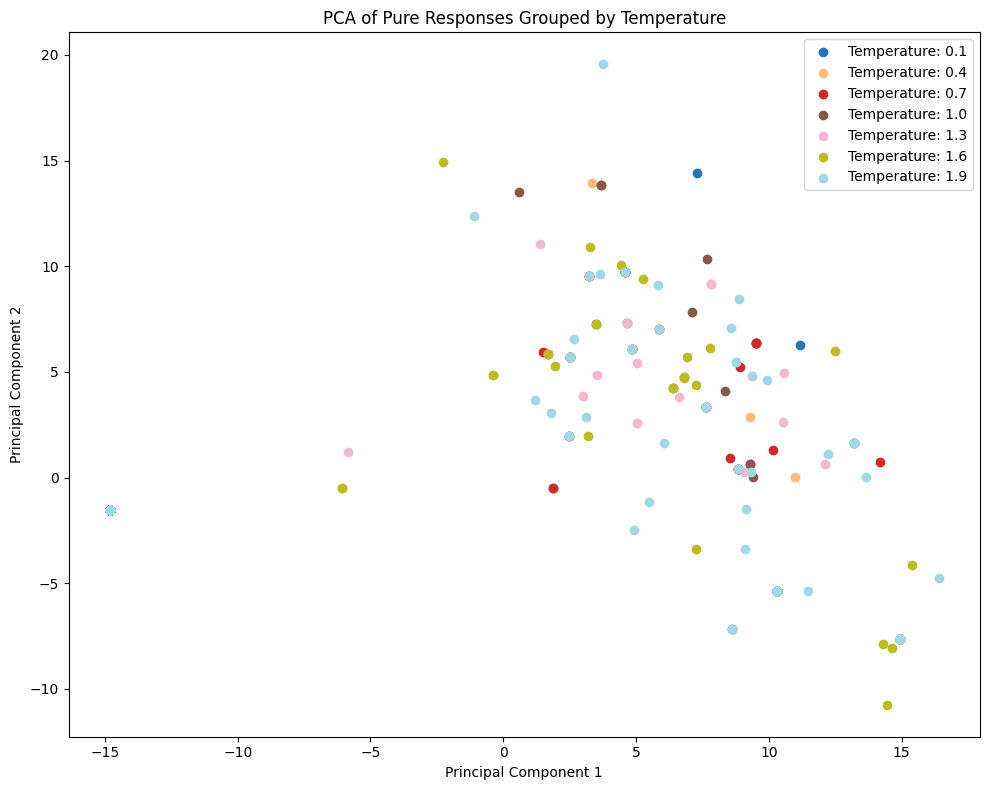

In [52]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from transformers import GPT2Tokenizer, GPT2Model
import torch

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")


def get_paragraph_embedding(paragraph):
    inputs = tokenizer(paragraph, return_tensors="pt", max_length=1024, truncation=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].detach().numpy()


# Assuming df is your DataFrame
temperatures = df["Temperature"].tolist()
grouped_responses = {}
for index, row in df.iterrows():
    temp = row["Temperature"]
    if row["Temperature"] not in grouped_responses:
        grouped_responses[temp] = []
    grouped_responses[temp].append(index)

plt.figure(figsize=(10, 8))

colors = plt.cm.get_cmap("tab20", len(grouped_responses))

all_embeddings = []
all_labels = []

for i, (temp, indices) in enumerate(grouped_responses.items()):
    group_responses = df.loc[indices, "pure_response"].tolist()
    embeddings = np.vstack(
        [get_paragraph_embedding(response) for response in group_responses]
    )
    all_embeddings.append(embeddings)
    all_labels.extend([temp] * len(embeddings))

all_embeddings = np.vstack(all_embeddings)
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(all_embeddings)

for i, temp in enumerate(grouped_responses.keys()):
    indices = [j for j, label in enumerate(all_labels) if label == temp]
    plt.scatter(
        reduced_embeddings[indices, 0],
        reduced_embeddings[indices, 1],
        label=f"Temperature: {temp}",
        color=colors(i),
    )

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Pure Responses Grouped by Temperature")
plt.legend()
plt.tight_layout()
plt.show()

In [76]:
len(all_labels)

504

In [77]:
all_embeddings.shape

(504, 768)

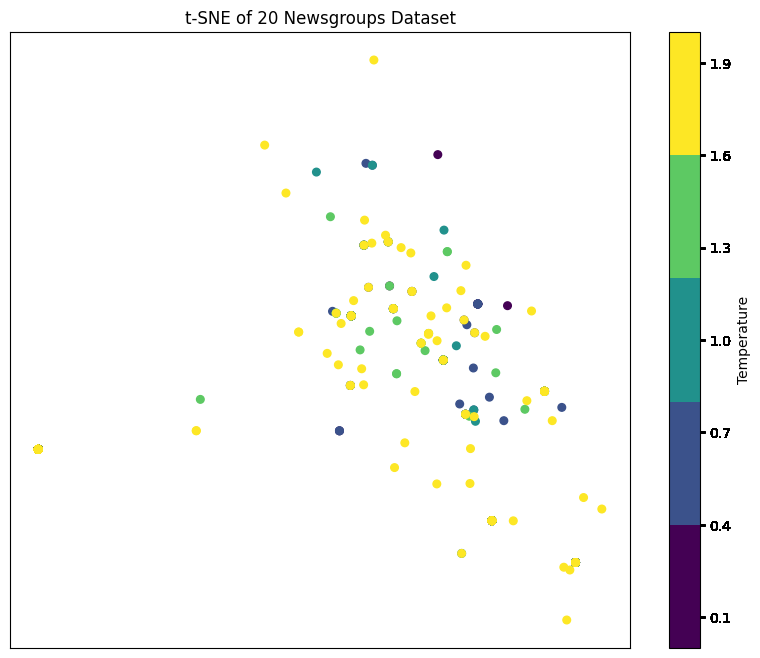

In [112]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.colors as mcolors

newsgroups = fetch_20newsgroups(
    subset="all",
    categories=[
        "rec.sport.baseball",
        "rec.sport.hockey",
        "sci.space",
        "talk.politics.misc",
    ],
)
X = newsgroups.data
y = newsgroups.target

vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X_vec = vectorizer.fit_transform(X)
X_vec = all_embeddings
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_vec)
pca = PCA(n_components=10)
X_embedded = pca.fit_transform(X_vec)
# 可视化结果
plt.figure(figsize=(10, 8))
cmap = mcolors.ListedColormap(["#440154", "#3b528b", "#21918c", "#5dc963", "#fde725"])
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=30)
plt.colorbar(scatter, ticks=all_labels, label="Temperature")
plt.clim(0.0, max(all_labels) + 0.1)
plt.xticks([])
plt.yticks([])
plt.title("t-SNE of 20 Newsgroups Dataset")
plt.show()

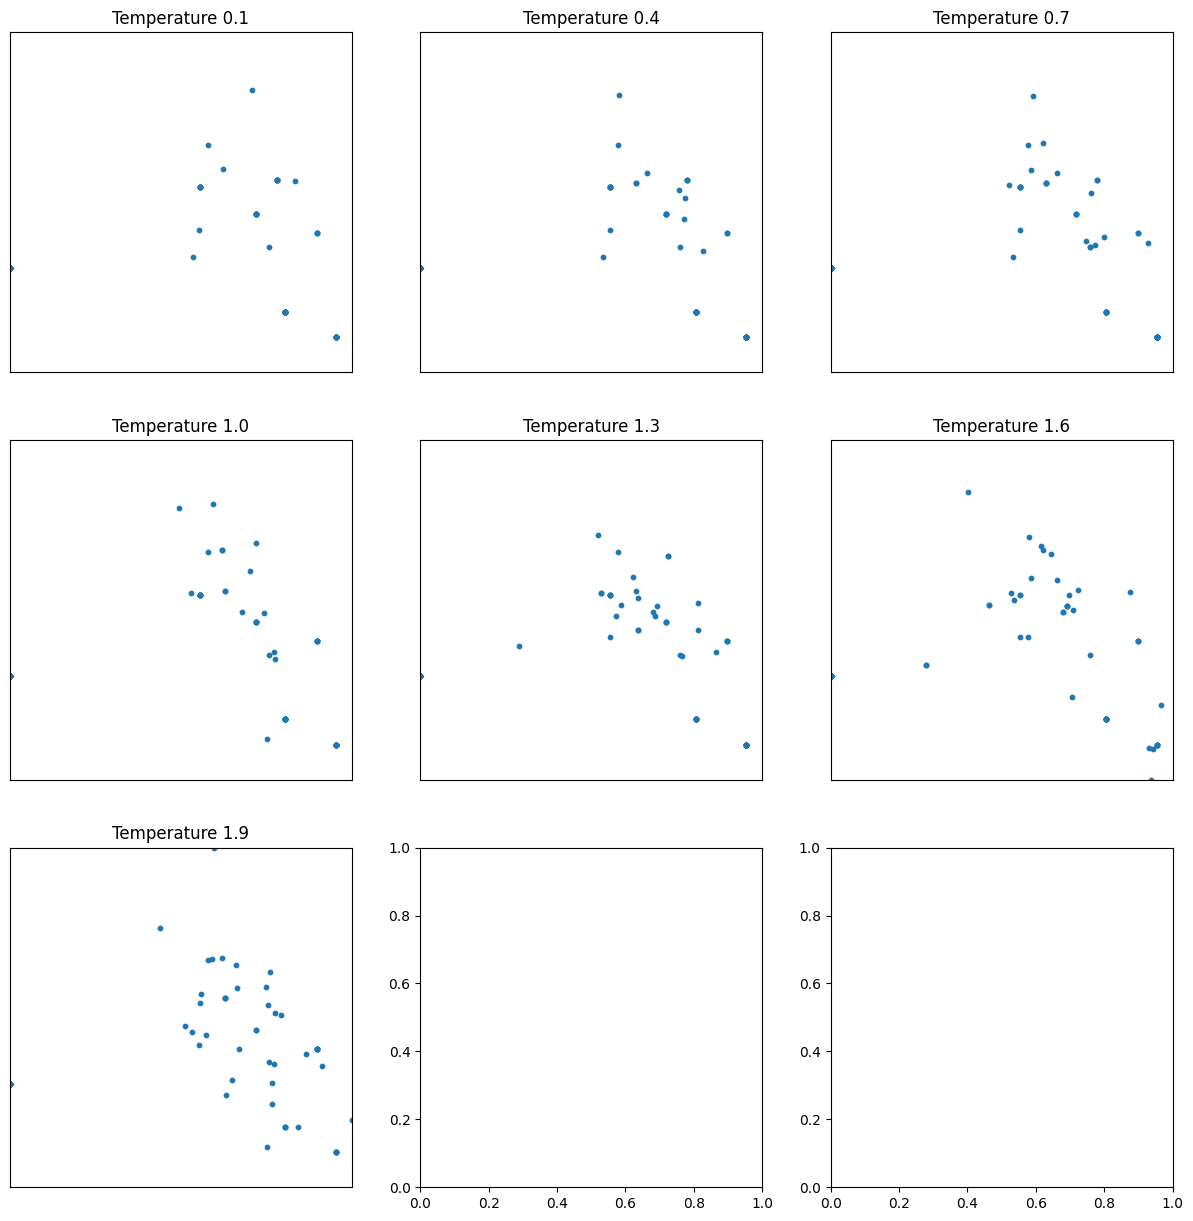

In [126]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
all_labels = np.array(all_labels)
unique_labels = list(sorted(set(all_labels)))
max_x = np.max(X_embedded[:, 0])
max_y = np.max(X_embedded[:, 1])
min_x = np.min(X_embedded[:, 0])
min_y = np.min(X_embedded[:, 1])

for label, ax in zip(range(7), axes.flat):
    temperature = unique_labels[label]
    label_indices = np.where(all_labels == temperature)[0]
    ax.scatter(
        X_embedded[label_indices, 0],
        X_embedded[label_indices, 1],
        s=10,
        label=f"Temperature {temperature}",
    )
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Temperature {temperature}")

In [117]:
X_embedded

array([[ 9.524653  ,  6.3517537 , -5.2153454 , ...,  0.11346173,
        -0.12536433,  1.0723069 ],
       [ 7.618127  ,  3.3149538 , -1.9737141 , ..., -0.74285936,
        -0.1172322 , -0.668472  ],
       [ 4.6417375 ,  7.3282275 ,  1.8252167 , ...,  0.8015584 ,
        -0.22361869,  0.19773099],
       ...,
       [ 9.930122  ,  4.6017284 , -4.1336    , ...,  0.44944784,
         0.14712074,  0.9722895 ],
       [ 3.0974026 ,  2.8445878 ,  1.1968971 , ..., -0.63602793,
         0.11458481,  1.7446797 ],
       [ 4.916845  , -2.5028927 ,  0.42028219, ..., -1.5389996 ,
         0.7675513 ,  2.4004445 ]], dtype=float32)

In [ ]:
for i, temp in enumerate(grouped_responses.keys()):
    indices = [j for j, label in enumerate(all_labels) if label == temp]
    plt.scatter(
        reduced_embeddings[indices, 0],
        reduced_embeddings[indices, 1],
        label=f"Temperature: {temp}",
        color=colors(i),
    )

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Pure Responses Grouped by Temperature")
plt.legend()
plt.tight_layout()
plt.show()

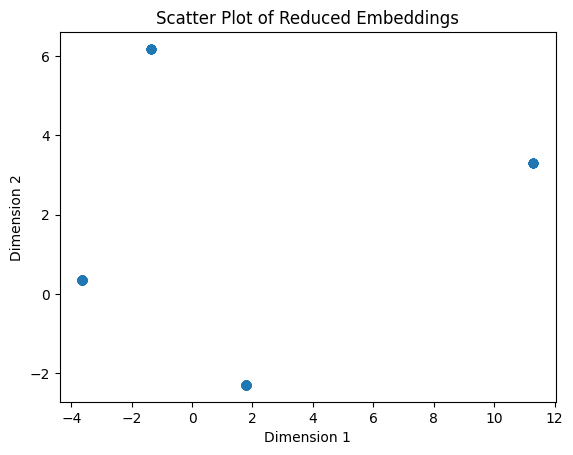

In [23]:
import matplotlib.pyplot as plt


def plot_scatter(reduced_embeddings):
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title("Scatter Plot of Reduced Embeddings")
    plt.show()


# 传入reduced_embeddings
plot_scatter(reduced_embeddings)

In [19]:
reduced_embeddings

array([[ 1.8089392 , -2.3053126 ],
       [-3.6253824 ,  0.30389977],
       [-1.3659229 ,  6.1981373 ],
       [-3.6253824 ,  0.30390102],
       [ 1.808939  , -2.3053102 ],
       [-3.6253824 ,  0.30390102],
       [11.299202  ,  3.2463155 ],
       [ 1.808939  , -2.3053102 ],
       [ 1.808939  , -2.3053102 ],
       [-3.6253824 ,  0.30390102],
       [-3.6253824 ,  0.30390102],
       [ 1.808939  , -2.3053102 ],
       [ 1.808939  , -2.3053102 ],
       [-3.6253824 ,  0.30390102],
       [-1.3659232 ,  6.1981373 ],
       [-3.6253824 ,  0.30390102],
       [ 1.808939  , -2.3053102 ],
       [-3.6253824 ,  0.30390102],
       [11.299202  ,  3.2463155 ],
       [ 1.808939  , -2.3053102 ],
       [ 1.808939  , -2.3053102 ],
       [-3.6253824 ,  0.30390102],
       [-3.6253824 ,  0.30390102],
       [ 1.808939  , -2.3053102 ],
       [ 1.808939  , -2.3053102 ],
       [-3.6253824 ,  0.30390102],
       [-1.3659232 ,  6.1981373 ],
       [-3.6253824 ,  0.30390102],
       [ 1.808939  ,

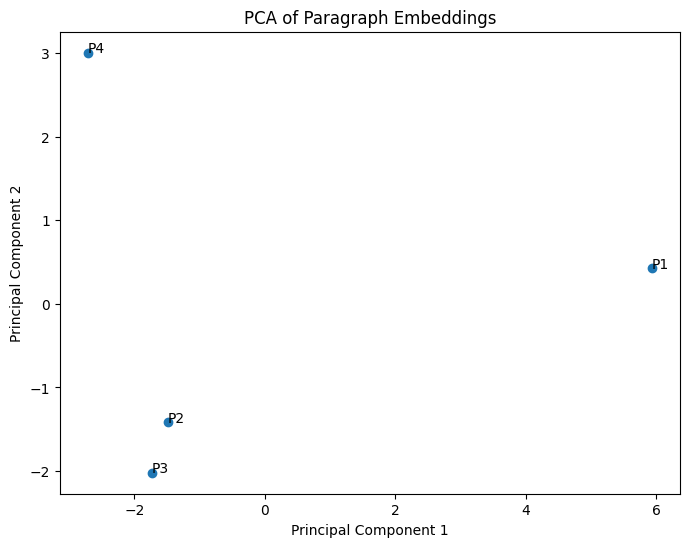

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from transformers import BertModel, BertTokenizer

# On creativity
paragraphs = [
    "This is the first paragraph. 12312312 sdfsdagds fsdfsad sfs fsa fsadf sad f",
    "Here is another paragraph.",
    "This paragraph is different from the others.",
    "Yet another example of a paragraph.",
]

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)


def get_paragraph_embedding(paragraph):
    inputs = tokenizer(paragraph, return_tensors="pt", max_length=1024, truncation=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].detach().numpy()


embeddings = np.vstack([get_paragraph_embedding(paragraph) for paragraph in paragraphs])

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])

for i, paragraph in enumerate(paragraphs):
    plt.annotate(f"P{i+1}", (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Paragraph Embeddings")
plt.show()

/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lujun/anaconda3/envs/causalLLM/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and wi

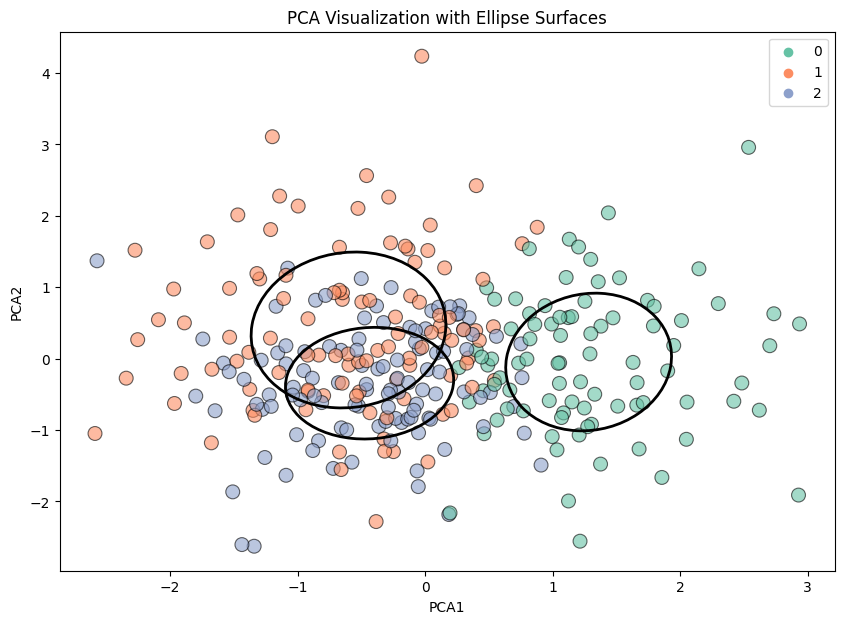

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.patches import Ellipse

# Generate some synthetic data for demonstration
np.random.seed(0)
data = np.random.randn(300, 5)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(data)

# Create a DataFrame with PCA results and cluster labels
df = pd.DataFrame(pca_result, columns=["PCA1", "PCA2"])
df["Cluster"] = clusters

# Plot PCA results with ellipses
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x="PCA1",
    y="PCA2",
    hue="Cluster",
    palette="Set2",
    data=df,
    s=100,
    alpha=0.6,
    edgecolor="k",
)

# Draw ellipses for each cluster
for cluster in np.unique(clusters):
    cluster_data = df[df["Cluster"] == cluster]
    cov = np.cov(cluster_data[["PCA1", "PCA2"]].values.T)
    mean = cluster_data[["PCA1", "PCA2"]].mean().values
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues)
    ell = Ellipse(
        xy=mean,
        width=width,
        height=height,
        angle=angle,
        edgecolor="black",
        fc="None",
        lw=2,
    )
    plt.gca().add_patch(ell)

plt.title("PCA Visualization with Ellipse Surfaces")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()